In [4]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import lorenz96

warnings.filterwarnings('ignore')
os.makedirs('./save_models', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

### 1. Plot Clusters

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
np.random.seed(seed)
# random.seed(seed)
# rng = np.random.RandomState(seed=seed)

In [3]:
#General hyper parameters
num_epochs = 20         # number of epochs
num_batch = 500        # number of batch
learning_rate = 0.001   # learning rate
image_size = 28*28      # size of image
label_size = 10
samplingInterval = 0.05

#Special hyper parameters
systemCount = 500

#iterationSize = 25

# Do you use a GPU?
if torch.cuda.is_available():
   device = 'cuda'
   torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
   device = 'cpu'

# transformation
transform = transforms.Compose([
    transforms.ToTensor()
    ])

# Obtain MNIST data
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
# for training
train_dataset = datasets.MNIST(
    '../data',               # directory of data
    train = True,           # obtain training data
    download = True,        # if you don't have data, download
    transform = transform   # trainsform to tensor
    )
# evaluation
test_dataset = datasets.MNIST(
    '../data', 
    train = False,
    transform = transform
    )

# data loader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = num_batch,
    shuffle = True,
    #num_workers = 2,
    generator=torch.Generator(device='cuda')
    )
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,     
    batch_size = num_batch,
    shuffle = False,
    #num_workers = 2,
    generator=torch.Generator(device='cuda')
    )


## 1. Training 

In [ ]:
fs = [0.5, 1.0, 1.5, 2.5, 3.0, 3.5, 4.0, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
iterations = [4]*len(fs)  

for f, iteration in zip(fs, iterations):
    print(f'~~~~ f = {f}, t = {iteration} ~~~~')
    commandLineConfigs = {"f": f , "iteration": iteration}

    model = lorenz96.ODEBlock(image_size, label_size, systemCount, commandLineConfigs).to(device)
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

    bestResult = 0
    bestLoss = 1e6

    initialStates = np.empty([0,systemCount])
    finalStates = np.empty([0,systemCount])
    class_labels = np.empty([0])

    for epoch in tqdm(range(num_epochs)): 
        initialStates = np.empty([0,systemCount])
        finalStates = np.empty([0,systemCount])
        # train
        model.train()  
        loss_sum = 0    
        for inputs, labels in train_dataloader:

            # send data to gpu, if gpu can be used
            inputs = inputs.to(device)
            labels = labels.to(device)

            # initialize optimizer
            optimizer.zero_grad()

            # process neural net
            inputs = inputs.view(-1, image_size) # reshape the data
            outputs = model(inputs)

            #save initial and final states for PCA
            # initialStates = np.concatenate([initialStates, model.initialStates.cpu().detach().numpy()])
            # finalStates = np.concatenate([finalStates, model.finalStates.cpu().detach().numpy()])

            # calculate loss
            loss = criterion(outputs, labels)
            loss_sum += loss

            # calculate gradient
            loss.backward()

            # optimize the weight
            optimizer.step()

        #torch.save(model.state_dict(), 'model_weights_after.pth')
        #np.savetxt("weight_after.txt", model.fc1.weight.cpu().detach().numpy())

        #PCA make PC vectors
        # pca_initialStates = PCA(n_components=n_components)
        # pca_initialStates.fit(initialStates)

        # pca_finalStates = PCA(n_components=n_components)
        # pca_finalStates.fit(finalStates)        

        #----------------------------------------------------------
        # evaluate
        model.eval()  # change model mode to the evaluation

        loss_sum = 0
        correct = 0
        count = 0

        first = True
        y_pred = np.empty((0), int)
        y_test = np.empty((0), int)

        with torch.no_grad():

            for inputs, labels in test_dataloader:

                # send data to gpu, if gpu can be used
                inputs = inputs.to(device)
                labels = labels.to(device)

                # process neural net
                inputs = inputs.view(-1, image_size) 
                # if first:
                #     outputs = model.forward_plot(inputs)
                #     stateFigureFileName = "figure/colormap/" + configName + "_epoch=" + str(epoch)
                #     model.plotStates(stateFigureFileName)
                #     first = False
                # else:
                outputs = model(inputs)

                #save initial and final states and labels for PCA
                if epoch + 1 == num_epochs:
                    initialStates = np.concatenate([initialStates, model.initialStates.cpu().detach().numpy()])
                    finalStates = np.concatenate([finalStates, model.finalStates.cpu().detach().numpy()])
                    class_labels = np.concatenate([class_labels, labels.cpu().detach().numpy()]) 

                # calculate loss
                loss_sum += criterion(outputs, labels)

                # obtain answer labels
                pred = outputs.argmax(1)
                # count correct data
                correct += pred.eq(labels.view_as(pred)).sum().item()
                count += 1               
                #hoge = pred.cpu().detach().numpy()
                y_pred = np.append(y_pred, pred.cpu().detach().numpy())
                y_test = np.append(y_test, labels.view_as(pred).cpu().detach().numpy())
                pred = outputs.argmax(1)
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss_sum.item() / len(test_dataloader)}, Accuracy: {100*correct/len(test_dataset)}% ({correct}/{len(test_dataset)})")
            bestResult = max(correct/len(test_dataset), bestResult)
            bestLoss = min(loss_sum.item() / len(test_dataloader), bestLoss)

    weightFileName = f'./save_models/lorenz_f{f}_t{iteration}.pth'
    torch.save(model.state_dict(), weightFileName)


## 2. Plot State

In [4]:
def cal_ISOmap(feat, y_labels):
    feat_reduced = Isomap(n_components=2).fit_transform(feat)
    feat_reduced_df = pd.DataFrame.from_dict({'Class': [], 'n1': [], 'n2': []})
    for i in range(10):
        mask = y_labels == i
        data = feat_reduced[mask]
        for row in data:
            new_row = pd.DataFrame([[i, row[0], row[1]]], columns=feat_reduced_df.columns)
            feat_reduced_df = pd.concat([feat_reduced_df, new_row], ignore_index=True)
    feat_reduced_df['Class'] = feat_reduced_df['Class'].astype(int)
    return feat_reduced_df

def cal_PCA(feat, y_labels):
    feat_reduced = PCA(n_components=2).fit_transform(feat)
    feat_reduced_df = pd.DataFrame.from_dict({'Class': [], 'n1': [], 'n2': []})
    for i in range(10):
        mask = y_labels == i
        data = feat_reduced[mask]
        for row in data:
            new_row = pd.DataFrame([[i, row[0], row[1]]], columns=feat_reduced_df.columns)
            feat_reduced_df = pd.concat([feat_reduced_df, new_row], ignore_index=True)
    feat_reduced_df['Class'] = feat_reduced_df['Class'].astype(int)
    return feat_reduced_df

def plot_pca(state, y_test, classes, save=False, file_name='', img_format='eps'):
    mask = (y_test == classes[0]) | (y_test == classes[1])
    filtered_data = state[mask]
    filtered_labels = labels[mask]

    deep_palette = sns.color_palette("deep")
    pca_palette = {classes[0]: deep_palette[classes[0]], classes[1]: deep_palette[classes[1]]}

    pca = PCA(n_components=2)
    X_pca_filtered = pca.fit_transform(filtered_data)
    df = pd.DataFrame(X_pca_filtered, columns=['PC1', 'PC2'])
    df['Label'] = filtered_labels

    fig = plt.figure(figsize=(8, 8))
    fig.set_facecolor('white')
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette=pca_palette, alpha=0.8, legend=False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(file_name, format=img_format)

def eval_state(model):
    initialStates = np.empty([0,systemCount])
    finalStates = np.empty([0,systemCount])
    class_labels = np.empty([0])
    criterion = nn.CrossEntropyLoss() 

    model.eval()  # change model mode to the evaluation
    loss_sum = 0
    correct = 0
    count = 0

    y_pred = np.empty((0), int)
    y_test = np.empty((0), int)

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # send data to gpu, if gpu can be used
            inputs = inputs.to(device)
            labels = labels.to(device)

            # process neural net
            inputs = inputs.view(-1, image_size) 
            # if first:
            #     outputs = model.forward_plot(inputs)
            #     stateFigureFileName = "figure/colormap/" + configName + "_epoch=" + str(epoch)
            #     model.plotStates(stateFigureFileName)
            #     first = False
            # else:
            outputs = model(inputs)

            #save initial and final states and labels for PCA
            initialStates = np.concatenate([initialStates, model.initialStates.cpu().detach().numpy()])
            finalStates = np.concatenate([finalStates, model.finalStates.cpu().detach().numpy()])
            class_labels = np.concatenate([class_labels, labels.cpu().detach().numpy()]) 

            # calculate loss
            loss_sum += criterion(outputs, labels)

            # obtain answer labels
            pred = outputs.argmax(1)
            # count correct data
            correct += pred.eq(labels.view_as(pred)).sum().item()
            count += 1               
            #hoge = pred.cpu().detach().numpy()
            y_pred = np.append(y_pred, pred.cpu().detach().numpy())
            y_test = np.append(y_test, labels.view_as(pred).cpu().detach().numpy())
            pred = outputs.argmax(1)
        print(f"Loss: {loss_sum.item() / len(test_dataloader)}, Accuracy: {100*correct/len(test_dataset)}% ({correct}/{len(test_dataset)})")
    return initialStates, finalStates, class_labels

colors = sns.color_palette("deep") # default has 10 colors
classes = np.arange(10) # index of each category, for MNIST is 0-9
palette = {}
for color, idx in zip(colors, classes):
    palette[idx] = color

#### F=0.1, T=2.5

In [5]:
model = lorenz96.ODEBlock(image_size, label_size, systemCount, {"f": 0.1, "iteration": 2.5})
model.load_state_dict(torch.load('./save_models/lorenz_f0.1_t2.5.pth'))
model = model.to(device)
f01_initialStates, f01_finalStates, labels = eval_state(model)

Loss: 0.11852350234985351, Accuracy: 96.46% (9646/10000)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


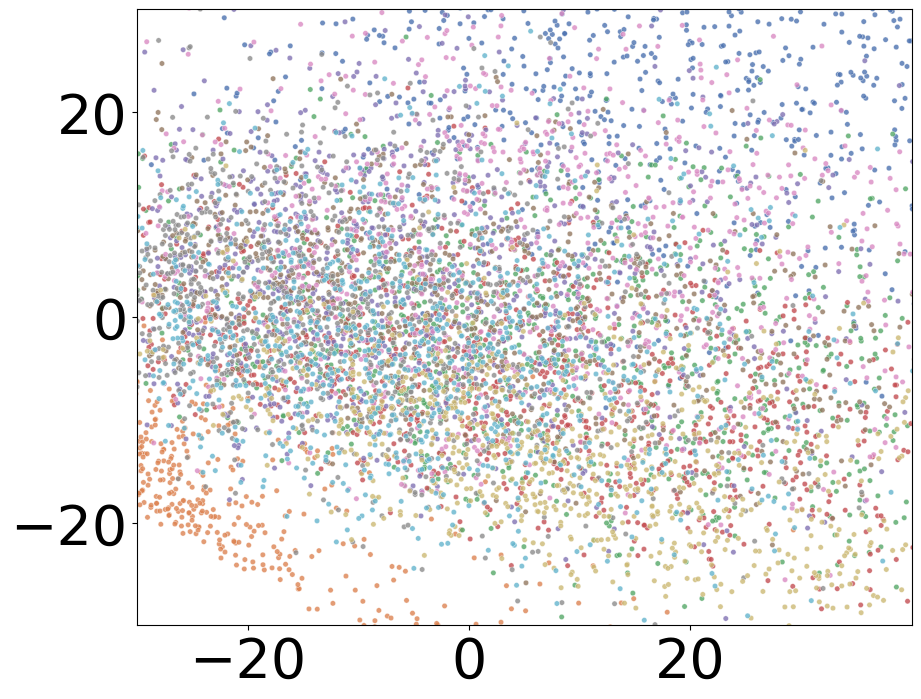

In [6]:
f01_df_initial = cal_PCA(f01_initialStates, labels)
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f01_df_initial, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xlim([-30, 40])
ax.set_ylim([-30, 30])
ax.set_xticks([-20, 0, 20])
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.savefig(f'./figures/lorenz_f0.1_initial_state.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


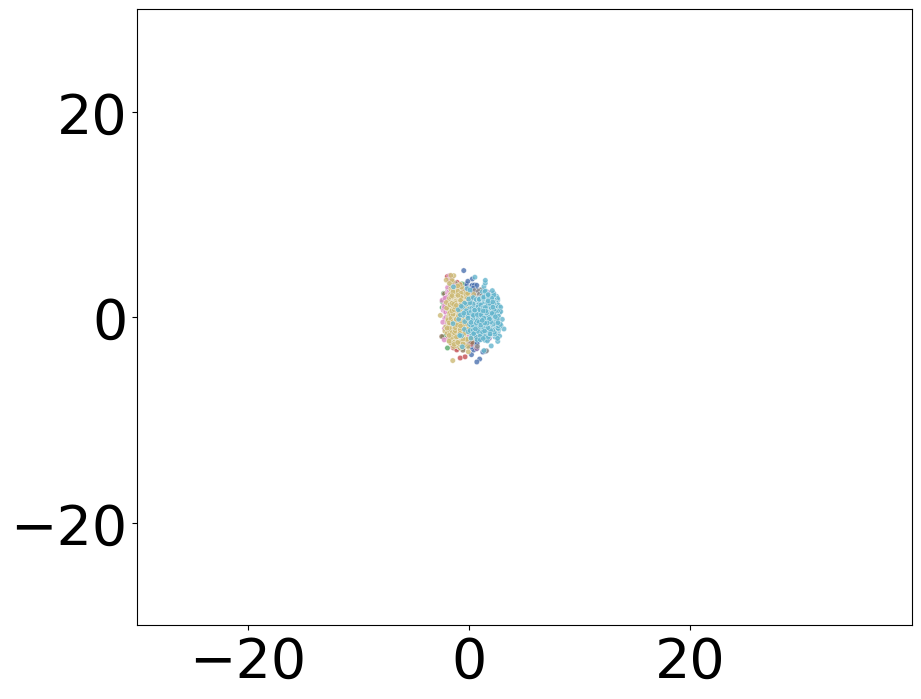

In [7]:
f01_df = cal_PCA(f01_finalStates, labels)
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f01_df, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xlim([-30, 40])
ax.set_ylim([-30, 30])
ax.set_xticks([-20, 0, 20])
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.savefig(f'./figures/lorenz_f0.1_final_state.eps', format='eps', transparent=True)
# plt.savefig(f'./figures/lorenz_f0.1_final_state.png', format='png', transparent=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


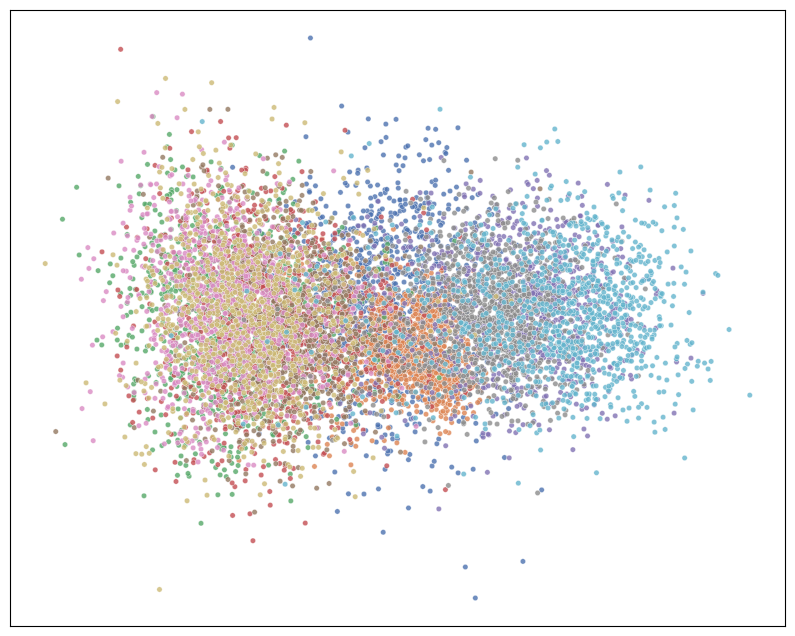

In [12]:
plt.figure(figsize=(10,8), facecolor='none')
ax = sns.scatterplot(data=f01_df, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
# plt.tick_params(axis='both', which='major', labelsize=)
plt.savefig(f'./figures/lorenz_f0.1_final_state_pure.eps', format='eps', transparent=True)

In [35]:
plot_pca(f01_finalStates, labels, classes=[4, 9], save=True, file_name='./figures/lorenz_f0.1_finalstate_pca.eps', img_format='eps')
plot_pca(f01_finalStates, labels, classes=[4, 9], save=True, file_name='./figures/lorenz_f0.1_finalstate_pca.png', img_format='png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


#### F=2.0, T=2.4

In [8]:
model = lorenz96.ODEBlock(image_size, label_size, systemCount, {"f": 2.0, "iteration": 2.5})
model.load_state_dict(torch.load('./save_models/lorenz_f2.0_t2.5.pth'))
model = model.to(device)
f20_initialStates, f20_finalStates, labels = eval_state(model)

Loss: 0.0674226462841034, Accuracy: 98.09% (9809/10000)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


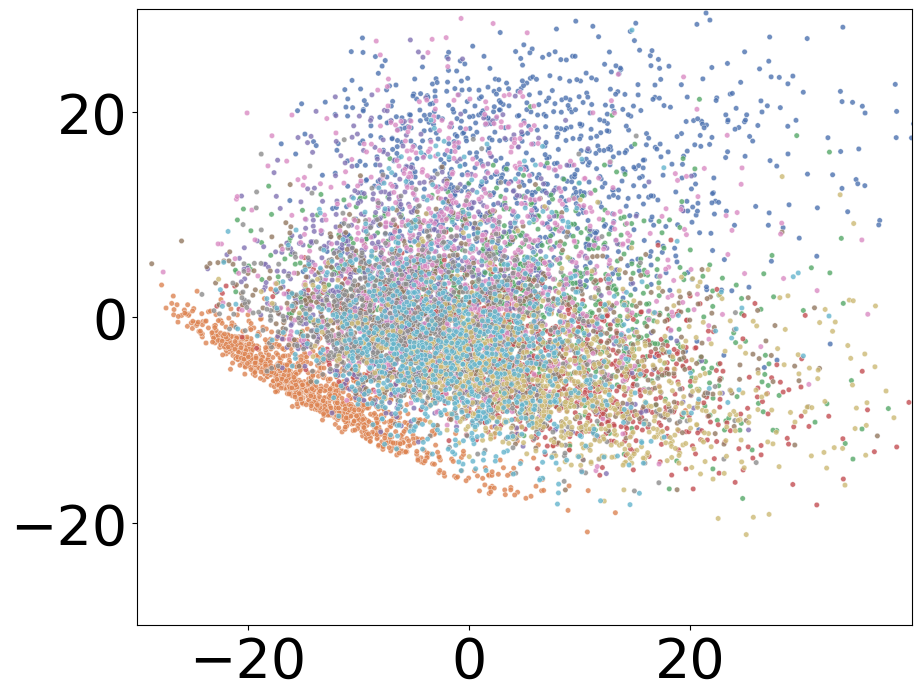

In [9]:
f20_df_initial = cal_PCA(f20_initialStates, labels)
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f20_df_initial, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xlim([-30, 40])
ax.set_ylim([-30, 30])
ax.set_xticks([-20, 0, 20])
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.savefig(f'./figures/lorenz_f2.0_initial_state.eps', format='eps', transparent=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


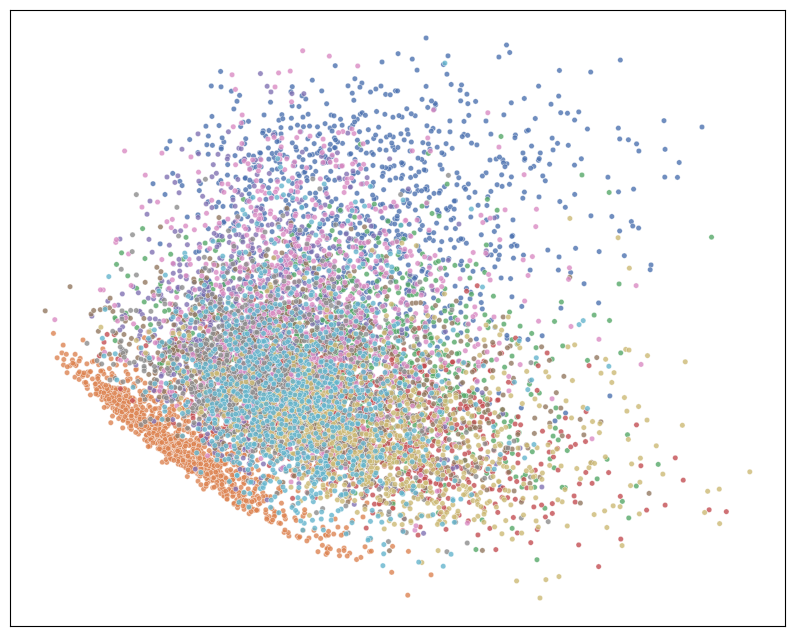

In [16]:
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f20_df_initial, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
# plt.tick_params(axis='both', which='major', labelsize=26)
plt.savefig(f'./figures/lorenz_f2.0_initial_state_pure.eps', format='eps', transparent=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


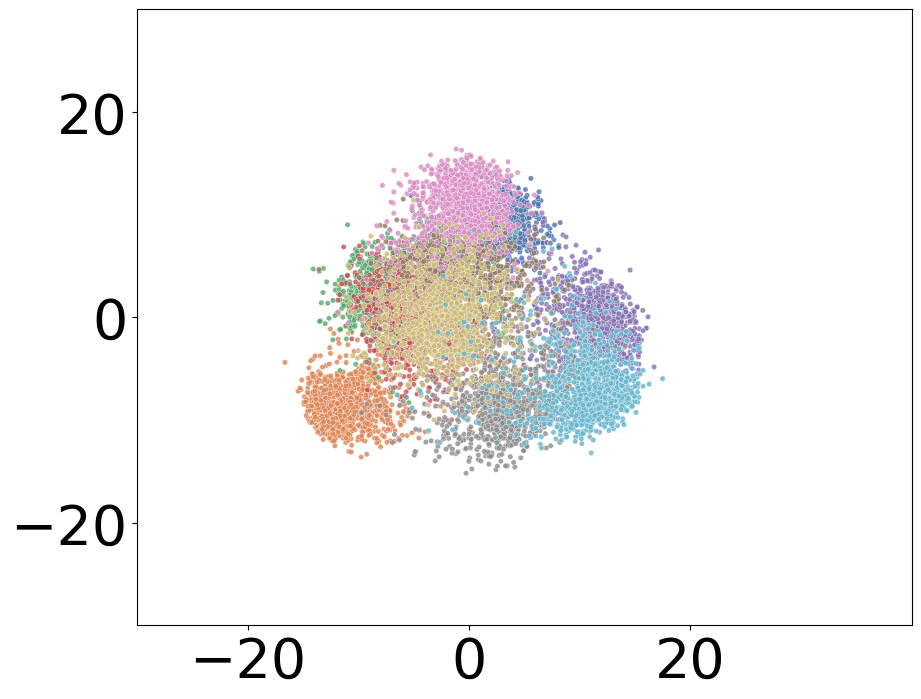

In [10]:
f20_df = cal_PCA(f20_finalStates, labels)
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f20_df, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xlim([-30, 40])
ax.set_ylim([-30, 30])
ax.set_xticks([-20, 0, 20])
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.savefig(f'./figures/lorenz_f2.0_final_state.eps', format='eps', transparent=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


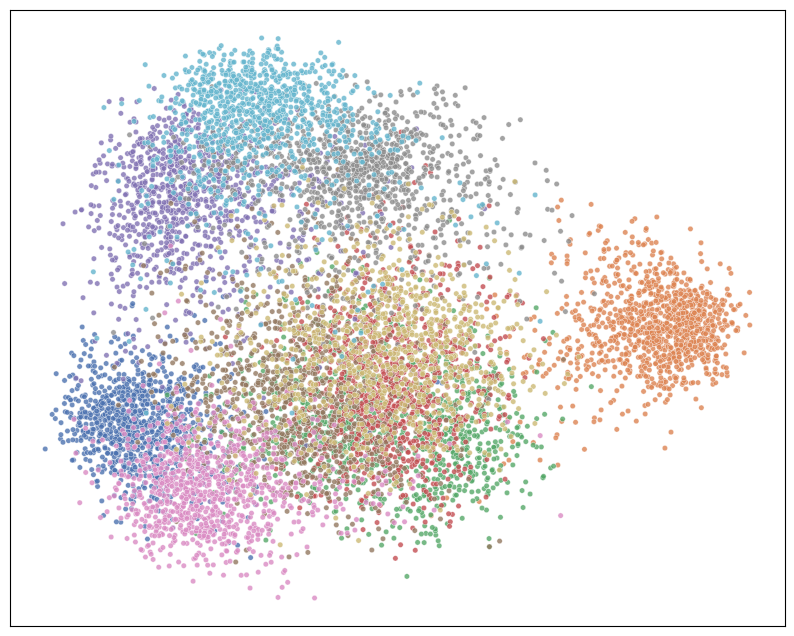

In [16]:
plt.figure(figsize=(10,8), facecolor='none')
ax = sns.scatterplot(data=f20_df, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
# plt.tick_params(axis='both', which='major', labelsize=34)
plt.savefig(f'./figures/lorenz_f2.0_final_state_pure.eps', format='eps', transparent=True)

In [36]:
plot_pca(f20_finalStates,labels, classes=[2, 5], save=True, file_name='./figures/lorenz_f2.0_finalstate_pca.eps', img_format='eps')
plot_pca(f20_finalStates,labels, classes=[4, 9], save=True, file_name='./figures/lorenz_f2.0_finalstate_pca.png', img_format='png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


#### F=4.5, T=2.5

In [11]:
model = lorenz96.ODEBlock(image_size, label_size, systemCount, {"f": 4.5, "iteration": 2.5})
model.load_state_dict(torch.load('./save_models/lorenz_f4.5_t2.5.pth'))
model = model.to(device)
f45_initialStates, f45_finalStates, labels = eval_state(model)

Loss: 0.08898339271545411, Accuracy: 97.83% (9783/10000)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


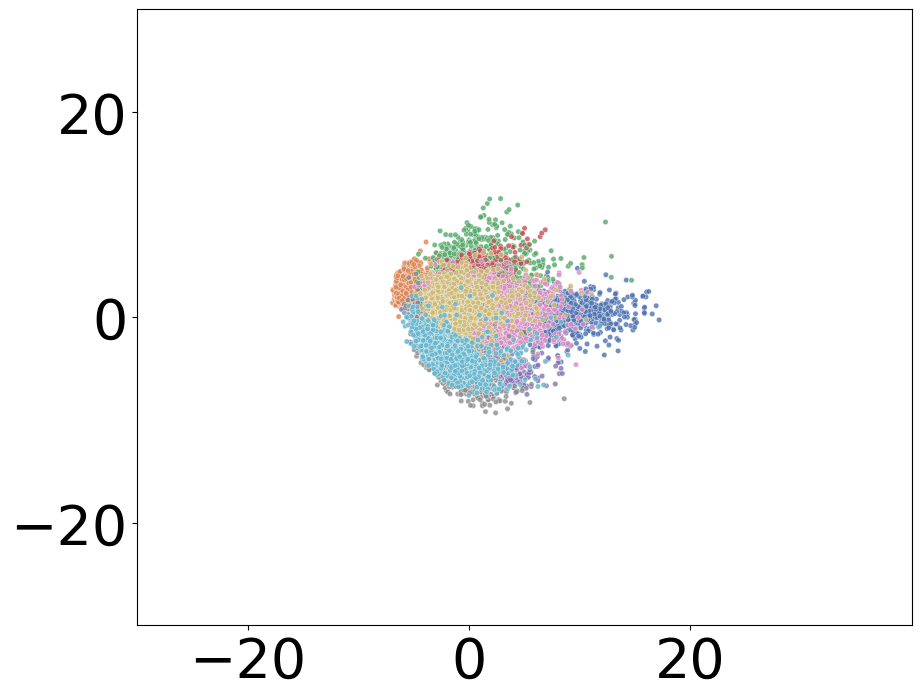

In [12]:
f45_df_initial = cal_PCA(f45_initialStates, labels)
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f45_df_initial, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xlim([-30, 40])
ax.set_ylim([-30, 30])
ax.set_xticks([-20, 0, 20])
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.savefig(f'./figures/lorenz_f4.5_initial_state.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


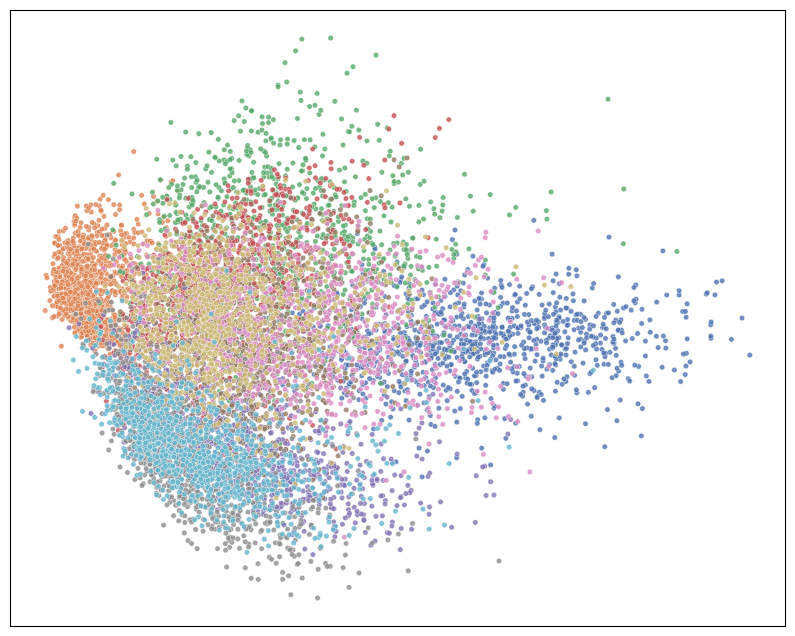

In [22]:
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f45_df_initial, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
# plt.tick_params(axis='both', which='major', labelsize=34)
plt.savefig(f'./figures/lorenz_f4.5_initial_state_pure.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


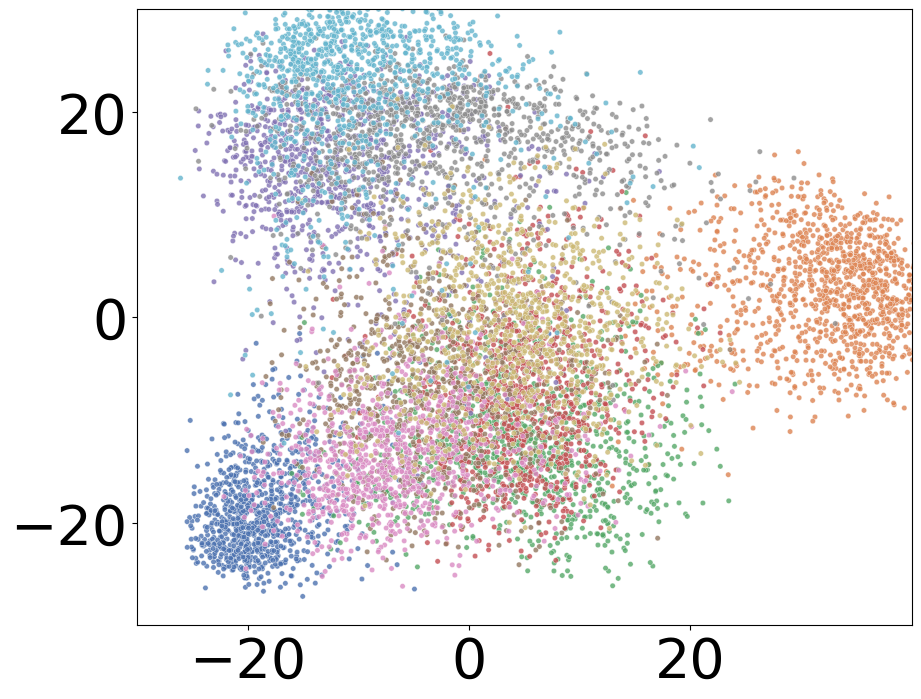

In [13]:
f45_df = cal_PCA(f45_finalStates, labels)
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=f45_df, x='n1', y='n2', hue='Class', palette=palette, marker='o', alpha=0.8, s=15, legend=False)
ax.set_xlim([-30, 40])
ax.set_ylim([-30, 30])
ax.set_xticks([-20, 0, 20])
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.legend(loc='upper right', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.savefig(f'./figures/lorenz_f4.5_final_state.eps', format='eps', transparent=True)

In [38]:
plot_pca(f45_finalStates, labels, classes=[4, 9], save=True, file_name='./figures/lorenz_f4.5_finalstate_pca.eps', img_format='eps')
plot_pca(f45_finalStates, labels, classes=[4, 9], save=True, file_name='./figures/lorenz_f4.5_finalstate_pca.png', img_format='png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### 2. Plot dynamics

In [9]:
def plot_dynamics(f, iteration):
    model = lorenz96.ODEBlock(image_size, label_size, systemCount, {"f": f, "iteration": iteration})
    model.load_state_dict(torch.load(f'./save_models/lorenz_f{f}_t{iteration}.pth'))
    model = model.to(device)    

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # send data to gpu, if gpu can be used
            inputs = inputs.to(device)
            labels = labels.to(device)

            # process neural net
            inputs = inputs.view(-1, image_size) 
            outputs = model.forward_plot(inputs)
            stateFigureFileName = f'figures/dynamics/f{f}_t{iteration}'
            model.plotStates(stateFigureFileName)
            

In [10]:
# F=0.1, T=2.5
plot_dynamics(f=0.1, iteration=2.5)

In [11]:
# F=0.1, T=2.5
plot_dynamics(f=2.0, iteration=2.5)

In [12]:
# F=0.1, T=2.5
plot_dynamics(f=4.5, iteration=2.5)